In [4]:
import os
import sys
import math
#from liblibra_core import * 
#from libra_py import *
import numpy as np
import cProfile, pstats, io
import matplotlib.pyplot as plt
from scipy.special import gamma
from NumpyMIW import * #Calls below
import py3Dmol

#### Explicit function calls from NumpyMIW:
- MIW_Forces(X, params) : Used to compute MIW forces
- Write_Frame_To_XYZ(X, 1, filename) : Used in dyanmics for writing out trajectory to .xyz file.


### Set up the functions to compute potential/forces for a partcle in an D-dimensional harmonic potential.

$X =  [ [x_{00}, x_{01}, ...,  x_{0D}], [x_{10}, x_{11}, ...,  x_{1D}], ..., [x_{N0}, x_{N1}, ..., x_{ND}]]$

In [2]:
def Harmonic_Potential(X, xo, K):
    res = 0 
    for i in range(len(X)):
        for k in range(len(X[0])):
            res +=  .5 * K * (X[i][k] - xo)**2
    return(res)

#As it is written, xo is the same in all dimensions, i.e. most set up for potential centered at origin
def Harmonic_Forces(X, xo, K):
    F = np.zeros(X.shape)
    for i in range(len(X)):
        for k in range(len(X[0])):
            F[i][k] = - K * ( X[i][k] - xo ) 
    return(F)

def VerletDynamics(X, V, params, method = 0, filename = 0):
    dt = params["dt"]
    steps = params["steps"]
    
    if method == 0:
        K = params["K"]
        xo = params["xo"]

        F, U = MIW_Forces(X, params)
        F += Harmonic_Forces(X, xo, K)
        for i in range(steps):
            X = X + V * dt + .5 * np.divide(F, M) * dt * dt
            V = V + .5 * np.divide(F, M) * dt
            F, U = MIW_Forces(X, params)
            F += Harmonic_Forces(X, xo, K)
            V = V + .5 * np.divide(F, M) * dt

            if type(filename) != int:
                Write_Frame_To_XYZ(X, 1, filename)
                
def MDMin(X, V, params, method = 0, filename = 0):
    dt = params["dt"]
    steps = params["steps"]
    
    if method == 0:
        K = params["K"]
        xo = params["xo"]

        F, U = MIW_Forces(X, params)
        F += Harmonic_Forces(X, xo, K)
        for i in range(steps):
            X = X + V * dt + .5 * np.divide(F, M) * dt * dt
            V = .5 * np.divide(F, M) * dt
            F, U = MIW_Forces(X, params)
            F += Harmonic_Forces(X, xo, K)
            V = .5 * np.divide(F, M) * dt

            if type(filename) != int:
                Write_Frame_To_XYZ(X, 1, filename)

### Set up to view the scale of interactions between particles ($\sim x_2-x_1$), and between the particle and harmonic potential ($\sim x$).

This is just to give a very rough idea as to the scales at which we should expect to see interworld forces and interaction with the harmonic potential being on par with one another. Really this is just helpful for tuning of the K parameter.

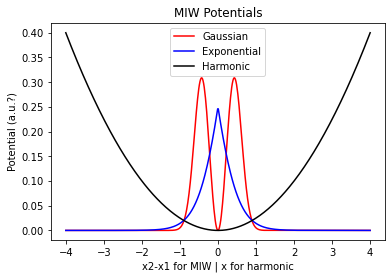

In [15]:
x1 = 0
start = -4
steps = 500
x2 = np.linspace(-start, start, steps)

b = .5
J = 1
D = 1
N = 2
X = np.zeros( ( N , J*D ) )
M = np.zeros( X.shape ) 
M += 1
params = {
    "J":J,
    "D":D,
    "b":b,
    "ktype":"gaussian",
    "M":M,
}


X = np.zeros( ( N , J*D ) )

X[0][0] = x1
GaussianPotentials = np.zeros( (len(x2), 1) )
ExponentialPotentials = np.zeros( (len(x2), 1) )
HarmonicPotentials = np.zeros( (len(x2), 1) )
                              
for i in range(len(x2)):
    X[1][0] = x2[i]
                              
    params["ktype"]="gaussian"
    F, U = MIW_Forces(X, params)
    GaussianPotentials[i] = U
                              
    params["ktype"]="exponential"
    F, U = MIW_Forces(X, params)
    ExponentialPotentials[i] = U
    
    HarmonicPotentials[i] = Harmonic_Potential(X, 0, .05)
                            

plt.figure(1)
plt.title("MIW Potentials")
plt.xlabel("x2-x1 for MIW | x for harmonic")
plt.ylabel("Potential (a.u.?)")
plt.plot(x2, GaussianPotentials, color = 'red', label = 'Gaussian')
plt.plot(x2, ExponentialPotentials, color ='blue', label = 'Exponential')
plt.plot(x2, HarmonicPotentials, color = 'black', label = 'Harmonic')
plt.legend();


### Now we can run some dynamics for a few particles in the harmonic potential.

In [67]:
N = 10
spacing = .5
X = Populate1DUniform(N, spacing)

V = np.zeros(X.shape)
M = np.zeros(X.shape)
M += 1

params = {
    "J":1,
    "D":1,
    "b":.5,
    "ktype":"gaussian",
    "M":M,
    "K":1,
    "xo":0,
    "dt":.1,
    "steps":100
}

file = "HarmonicTraj.xyz"
os.system("rm %s" % file)
VerletDynamics(X, V, params, filename = file)



In [3]:
N = 10
spacing = .5
X = Populate1DUniform(N, spacing)

V = np.zeros(X.shape)
M = np.zeros(X.shape)
M += 1

params = {
    "J":1,
    "D":1,
    "b":.5,
    "ktype":"gaussian",
    "M":M,
    "K":1,
    "xo":0,
    "dt":.1,
    "steps":500
}
file = "MDMin.xyz"
os.system("rm %s" % file)
MDMin(X, V, params, filename = file)